Clipping DEM/ICESat-2 data using polygons (GLIMS data)

In [1]:
# !pip install -e Assimilation

%load_ext autoreload
%autoreload 2

1. Reading DEM and ICESat-2 data



In [2]:
from simlib.coregistration import reference_dem
from simlib import atl06lib
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd

%matplotlib inline

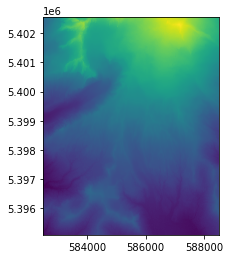

In [3]:
dem_path = '/srv/shared/data-knuth/reference_dem_clip.tif'
dem = reference_dem(dem_path)
dem.show()

Number of points: 894


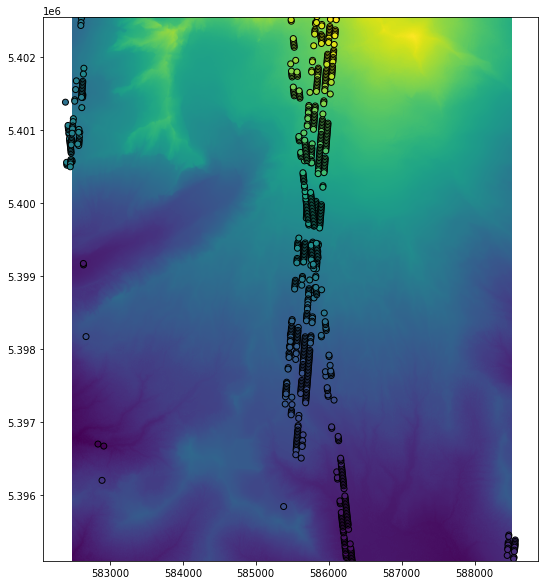

In [5]:
is2_paths = glob.glob('/home/jovyan/data/ICESat-2_Baker_Processed/*.h5')
# is2_paths = glob.glob('/srv/shared/data-whyjay/ICESat-2_Baker_Processed/*.h5')

# Variables we want to plot
vnames = ['x', 'y', 'h_li']
is2_dds = [dd.from_array(atl06lib.read_h5(f, vnames)[0], columns=vnames) for f in is2_paths]
is2_dd = dd.concat(is2_dds)
is2_ddf = is2_dd.compute()
is2_gpd = gpd.GeoDataFrame(is2_ddf, geometry=gpd.points_from_xy(is2_dd['x'], is2_dd['y']), crs='EPSG:' + dem.epsg)

print('Number of points:', len(is2_gpd))

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
is2_gpd.plot(ax=ax, column='h_li', edgecolor='black')


2. Reading GLIMS data at baker

(5395092.518148141, 5402543.276693823)

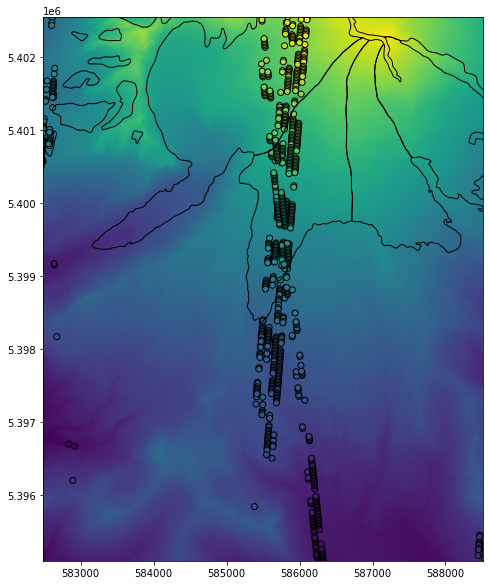

In [6]:
# !ogr2ogr -t_srs EPSG:32610 glims_polygons_EPSG32610.shp glims_polygons.shp

glims_path = '/srv/shared/data-whyjay/glims_mtBaker/glims_polygons_EPSG32610.shp'
shapefile = gpd.read_file(glims_path)

# shapefile['geometry'] = shapefile['geometry'].to_crs(epsg=int(dem.epsg))

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
is2_gpd.plot(ax=ax, column='h_li', edgecolor='black')
shapefile.plot(ax=ax, facecolor="none", edgecolor='black')
ax.set_xlim([dem.x.min(), dem.x.max()])
ax.set_ylim([dem.y.min(), dem.y.max()])


3. Apply the points-in-polygon algorithm and add a column "on_ice" (value = 1 or 0) to IS2 gpd array

In [7]:
# idx = atl06lib.points_in_polygon(is2_gpd[['x', 'y']].to_numpy(), glims_path)
idx = atl06lib.points_in_polygon(is2_gpd, glims_path)
is2_gpd['on_ice'] = idx
print(is2_gpd)

                x             y         h_li                        geometry  \
0   585820.033780  5.402471e+06  2641.562988  POINT (585820.034 5402470.987)   
1   585818.482160  5.402451e+06  2635.364014  POINT (585818.482 5402451.019)   
2   585812.354739  5.402371e+06  2603.774902  POINT (585812.355 5402371.143)   
3   585810.797554  5.402351e+06  2601.487793  POINT (585810.798 5402351.175)   
4   585809.211173  5.402331e+06  2599.798340  POINT (585809.211 5402331.202)   
..            ...           ...          ...                             ...   
3   588459.384185  5.395325e+06  1190.703979  POINT (588459.384 5395325.108)   
4   588457.824303  5.395305e+06  1184.791992  POINT (588457.824 5395305.140)   
5   588454.681982  5.395265e+06  1176.595703  POINT (588454.682 5395265.205)   
6   588453.107356  5.395245e+06  1172.540527  POINT (588453.107 5395245.238)   
7   588446.649630  5.395165e+06  1175.643066  POINT (588446.650 5395165.383)   

    on_ice  
0     True  
1     True  


(5395092.518148141, 5402543.276693823)

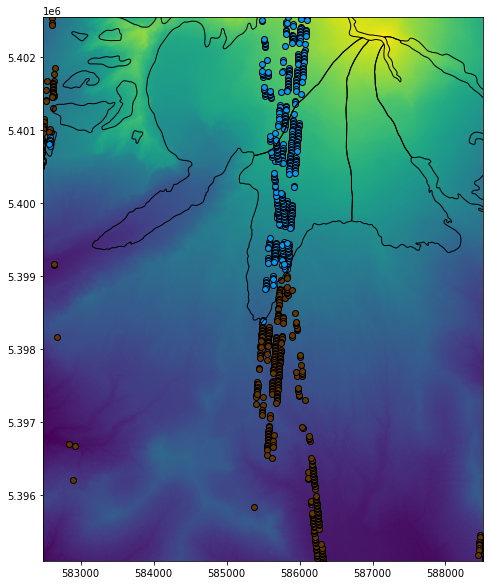

In [8]:
fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
is2_gpd[is2_gpd['on_ice'] == False].plot(ax=ax, facecolor='xkcd:brown', edgecolor='black')
is2_gpd[is2_gpd['on_ice'] == True].plot(ax=ax, facecolor='xkcd:azure', edgecolor='black')
shapefile.plot(ax=ax, facecolor="none", edgecolor='black')
ax.set_xlim([dem.x.min(), dem.x.max()])
ax.set_ylim([dem.y.min(), dem.y.max()])

4. Sample DEM heights at the ICESat location

In [9]:
is2_gpd = dem.Sample(is2_gpd)

In [10]:
is2_gpd['is2_dem_dh'] = is2_gpd['h_li'] - is2_gpd['h_dem']
is2_gpd

,x,y,h_li,geometry,on_ice,h_dem,is2_dem_dh
0,585820.033780,5.402471e+06,2641.562988,POINT (585820.034 5402470.987),True,2628.345459,13.217529
1,585818.482160,5.402451e+06,2635.364014,POINT (585818.482 5402451.019),True,2629.807129,5.556885
2,585812.354739,5.402371e+06,2603.774902,POINT (585812.355 5402371.143),True,2595.020752,8.754150
3,585810.797554,5.402351e+06,2601.487793,POINT (585810.798 5402351.175),True,2594.069092,7.418701
4,585809.211173,5.402331e+06,2599.798340,POINT (585809.211 5402331.202),True,2593.096191,6.702148
...,...,...,...,...,...,...,...
3,588459.384185,5.395325e+06,1190.703979,POINT (588459.384 5395325.108),False,1208.166016,-17.462036
4,588457.824303,5.395305e+06,1184.791992,POINT (588457.824 5395305.140),False,1205.843140,-21.051147
5,588454.681982,5.395265e+06,1176.595703,POINT (588454.682 5395265.205),False,1189.169922,-12.574219
6,588453.107356,5.395245e+06,1172.540527,POINT (588453.107 5395245.238),False,1172.451904,0.088623


5. Generate histograms showing on-ice and off-ice df distribution

In [11]:
# x.between(x.quantile(.15), x.quantile(.85))
goodpts_idx = is2_gpd['is2_dem_dh'].between(is2_gpd['is2_dem_dh'].quantile(.1), is2_gpd['is2_dem_dh'].quantile(.9))
# goodpts_idx = is2_gpd['is2_dem_dh'].between(-20, 20)
is2_gpd['is2_dem_dh'][goodpts_idx].describe()

count    714.000000
mean       2.357923
std        2.540896
min       -2.472412
25%        0.183197
50%        2.307373
75%        3.944702
max        8.418701
Name: is2_dem_dh, dtype: float64

Text(0.5, 0, 'dh (meters)')

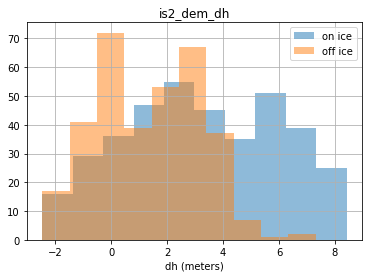

In [12]:
is2_gpd_good = is2_gpd[goodpts_idx]
is2_gpd_good_onice  = is2_gpd_good[is2_gpd_good['on_ice'] == True]
is2_gpd_good_office = is2_gpd_good[is2_gpd_good['on_ice'] == False]
fix, ax = plt.subplots()
is2_gpd_good_onice.hist(column='is2_dem_dh', ax=ax, label='on ice', alpha=0.5)
is2_gpd_good_office.hist(column='is2_dem_dh', ax=ax, label='off ice', alpha=0.5)
ax.legend()
ax.set_xlabel('dh (meters)')

In [ ]:
# dem.create_bare_rock_mask(method='RGI', polygon_shapefile=glims_path)